### Quality Control
1. select data only on Jan. and July.
2. no-data should be eliminated, and missing days has to be less than 10, and consecutive missing days less than 5
3. select KZ, from 1980 to 1990, all 11 years data are passed quality control.
4. map these data as red dots

##### In the GHCN data, missing column means the missing days within that month, easy understand as consective missing day.

In [1]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd

 I download the GHCN data split in 2 files, because such big file is forbidden to download  from NOAA's server.
 So, It needs to be concated.

In [2]:
ghcn1 = pd.read_csv('/home/ek777/Documents/Downscaling/GHCN_1980_1990_Ccentral_asia.csv')

month = ghcn1['DATE'].apply(lambda d: str(d)[4:6])
ghcn1['MONTH'] = month
ghcn1 = ghcn1.ix[(ghcn1['MONTH']=='01') | (ghcn1['MONTH']=='07'),:]

year = ghcn1['DATE'].apply(lambda d: str(d)[:4])
ghcn1['YEAR'] = year


ghcn2 = pd.read_csv('/home/ek777/Documents/Downscaling/GHCN_1990_2000_Ccentral_asia.csv')

month = ghcn2['DATE'].apply(lambda d: str(d)[4:6])
ghcn2['MONTH'] = month
ghcn2 = ghcn2.ix[(ghcn2['MONTH']=='01') | (ghcn2['MONTH']=='07'),:]

year = ghcn2['DATE'].apply(lambda d: str(d)[:4])
ghcn2['YEAR'] = year

In [3]:
ghcn_concated = pd.concat([ghcn1,ghcn2])
ghcn_sorted = ghcn_concated.sort_index(by=['STATION_NAME','YEAR','MONTH'])
ghcn_tmp_uncheck = ghcn_sorted[['STATION_NAME','MONTH','YEAR','MNTM','Missing.7','Consecutive Missing.7']]
ghcn_tmp_uncheck['MONTH'] = ghcn_tmp_uncheck['MONTH'].astype(int)
ghcn_tmp_uncheck['YEAR'] = ghcn_tmp_uncheck['YEAR'].astype(int)
ghcn_tmp_uncheck_80_2000 = ghcn_tmp_uncheck.ix[(ghcn_tmp_uncheck['YEAR']>=1980) & (ghcn_tmp_uncheck['YEAR']<=2000),:]

/home/ek777/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ek777/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Qualiti control

In [4]:

A_Set = ghcn_tmp_uncheck_80_2000['MNTM']!=-9999
B_Set = ghcn_tmp_uncheck_80_2000['Missing.7'] < 10
C_Set = ghcn_tmp_uncheck_80_2000['Consecutive Missing.7'] < 5

cond = (A_Set & B_Set & C_Set)

ghcn_passed = ghcn_tmp_uncheck_80_2000.ix[cond,:]

In [5]:
complete_year = ghcn_passed.groupby('STATION_NAME').count() >= 42
ghcn_passed_cp = complete_year[complete_year['MNTM']==True]
passed_names = DataFrame(ghcn_passed_cp.index)

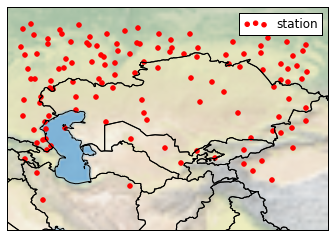

In [6]:
ghcn_xy = ghcn1[['STATION_NAME','LONGITUDE','LATITUDE']].drop_duplicates()

xy = pd.merge(passed_names,ghcn_xy,on='STATION_NAME',how='left')

lat = np.array(xy['LATITUDE'])
lon = np.array(xy['LONGITUDE'])


%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([42,88,30,60])

countries = cfeature.NaturalEarthFeature(\
                                        category='cultural',\
                                        name='admin_0_countries',\
                                        scale='50m',\
                                        facecolor='none')
ax.add_feature(countries)
dots = plt.scatter(lon, lat, color='red',transform=ccrs.Geodetic(),label='station')

ax.legend()
plt.show()

### Output to a .csv file, so I can use it later.

In [7]:
ghcn_passed_complete_data = pd.merge(passed_names,ghcn_passed,on='STATION_NAME',how='left')
ghcn_passed_complete_data = ghcn_passed_complete_data[['STATION_NAME','YEAR','MONTH','MNTM']]
ghcn_passed_complete_data.to_csv('GHCN_1980_2000_Central_Asia_Quality_Control.csv',index=False,header=True)